In [ ]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import openpyxl
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24
%config InlineBackend.figure_format = 'svg'
# 定义吉泽克斯模型微分方程
def dudt_giesekus(t, u, p, gradv):
    # 解构参数
    η0, τ, α = p

    # 应力张量的分量
    σ11, σ22, σ33, σ12, σ13, σ23 = u

    # 速度梯度张量
    v11, v12, v13, v21, v22, v23, v31, v32, v33 = gradv

    # 计算应变率（对称）和涡度（反对称）张量
    γd11 = 2 * v11(t)
    γd22 = 2 * v22(t)
    γd33 = 2 * v33(t)
    γd12 = v12(t) + v21(t)
    γd13 = v13(t) + v31(t)
    γd23 = v23(t) + v32(t)
    ω12 = v12(t) - v21(t)
    ω13 = v13(t) - v31(t)
    ω23 = v23(t) - v32(t)
    # 定义 Giesekus 模型的 F
    F11 = -τ * (σ11 * γd11 + σ12 * γd12 + σ13 * γd13) + (α * τ / η0) * (σ11**2 + σ12**2 + σ13**2)
    F22 = -τ * (σ12 * γd12 + σ22 * γd22 + σ23 * γd23) + (α * τ / η0) * (σ12**2 + σ22**2 + σ23**2)
    F33 = -τ * (σ13 * γd13 + σ23 * γd23 + σ33 * γd33) + (α * τ / η0) * (σ13**2 + σ23**2 + σ33**2)
    F12 = (-τ * (σ11 * γd12 + σ12 * γd22 + σ13 * γd23 + γd11 * σ12 + γd12 * σ22 + γd13 * σ23) / 2
           +
           (α * τ / η0) * (σ11 * σ12 + σ12 * σ22 + σ13 * σ23))
    F13 = (-τ * (σ11 * γd13 + σ12 * γd23 + σ13 * γd33 + γd11 * σ13 + γd12 * σ23 + γd13 * σ33) / 2
           +
           (α * τ / η0) * (σ11 * σ13 + σ12 * σ23 + σ13 * σ33))
    F23 = (-τ * (σ12 * γd13 + σ22 * γd23 + σ23 * γd33 + γd12 * σ13 + γd22 * σ23 + γd23 * σ33) / 2
           +
           (α * τ / η0) * (σ12 * σ13 + σ22 * σ23 + σ23 * σ33))

    # 模型微分方程
    du = np.zeros(6)
    du[0] = η0 * γd11 / τ - σ11 / τ - (ω12 * σ12 + ω13 * σ13) - F11 / τ
    du[1] = η0 * γd22 / τ - σ22 / τ - (ω23 * σ23 - ω12 * σ12) - F22 / τ
    du[2] = η0 * γd33 / τ - σ33 / τ + (ω13 * σ13 + ω23 * σ23) - F33 / τ
    du[3] = η0 * γd12 / τ - σ12 / τ - (ω12 * σ22 + ω13 * σ23 - σ11 * ω12 + σ13 * ω23) / 2 - F12 / τ
    du[4] = η0 * γd13 / τ - σ13 / τ - (ω12 * σ23 + ω13 * σ33 - σ11 * ω13 - σ12 * ω23) / 2 - F13 / τ
    du[5] = η0 * γd23 / τ - σ23 / τ - (ω23 * σ33 - ω12 * σ13 - σ12 * ω13 - σ22 * ω23) / 2 - F23 / τ

    return du

# 计算应变率
def compute_strain_rate(gradv, t):
    v11, v12, v13, v21, v22, v23, v31, v32, v33 = gradv

    # 计算应变率（对称）张量
    γd11 = 2 * v11(t)
    γd22 = 2 * v22(t)
    γd33 = 2 * v33(t)
    γd12 = v12(t) + v21(t)
    γd13 = v13(t) + v31(t)
    γd23 = v23(t) + v32(t)

    return [γd11, γd22, γd33, γd12, γd13, γd23]

# 生成 Giesekus 模型结果
# 生成 Giesekus 模型结果
def gen_giesekus_results(protocols, σ0, tspan, p_giesekus, datatype):
    protocols=protocols[-1:]
    wb = openpyxl.Workbook()

    # 初始化存储数据的列表
    all_time = []
    all_σ12_data = []
    all_γd12_data = []
    all_N1_data = []

    for k, gradv in enumerate(protocols):
        # 求解 Giesekus 模型
        def dudt(t, u):
            return dudt_giesekus(t, u, p_giesekus, gradv)

        sol = solve_ivp(dudt, tspan[:2], σ0, method='RK45', t_eval=np.linspace(tspan[0], tspan[1], tspan[2]))

        # 计算应变率
        strain_rate_data = np.array([compute_strain_rate(gradv, t) for t in sol.t]).T

        # 提取应力数据
        σ11_data = sol.y[0]
        σ22_data = sol.y[1]
        σ12_data = sol.y[3]

        # 提取应变率数据
        γd12_data = strain_rate_data[3]

        # 累积数据
        all_time.append(sol.t)
        all_σ12_data.append(σ12_data)
        all_γd12_data.append(γd12_data)
        all_N1_data.append(σ11_data - σ22_data)

    # 设置默认字体为Arial，字体大小为24
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 24

    # 1. 绘制时间-应力图
    fig1, ax1 = plt.subplots(figsize=(8, 6),dpi=600)
    for i in range(len(protocols)):
        ax1.plot(all_time[i], all_σ12_data[i], linewidth=3, label='linear')
    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("$\sigma_{12}$ (Pa)")
    ax1.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
    ax1.set_ylim([0, 1])
    plt.tight_layout()  # 调整布局
    plt.show()

    # 2. 绘制应变率-应力图
    fig2, ax2 = plt.subplots(figsize=(8, 6),dpi=600)
    for i in range(len(protocols)):
        ax2.plot(all_γd12_data[i], all_σ12_data[i], linewidth=2, label=f"Protocol {i+1}")
    ax2.set_xlabel(r"$\dot{\gamma}_{12}$ (s$^{-1}$)")
    ax2.set_ylabel("$\sigma_{12}$ (Pa)")
    ax2.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
    plt.tight_layout()  # 调整布局
    plt.show()

    # 3. 绘制应变率-第一法向应力差图
    fig3, ax3 = plt.subplots(figsize=(8, 6),dpi=600)
    for i in range(len(protocols)):
        ax3.plot(all_γd12_data[i], all_N1_data[i], linewidth=2, label=f"Protocol {i+1}")
    ax3.set_xlabel(r"$\dot{\gamma}_{12}$ (s$^{-1}$)")
    ax3.set_ylabel("N$_1$ (Pa)")
    ax3.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
   # ax3.set_ylim([0, 2.1])
    plt.tight_layout()  # 调整布局
    plt.show()

        # 将数据写入 Excel 文件
    ''' sheet = wb.create_sheet(title=f"protocol_{k}")
        headers = ["Time", "γd11", "γd22", "γd33", "γd12", "γd13", "γd23", "σ11", "σ22", "σ33", "σ12", "σ13", "σ23"]
        for col_idx, header in enumerate(headers, start=1):
            sheet.cell(row=1, column=col_idx, value=header)

        for row_idx, t in enumerate(sol.t, start=2):
            sheet.cell(row=row_idx, column=1, value=t)
            sheet.cell(row=row_idx, column=2, value=γd11_data[row_idx - 2])
            sheet.cell(row=row_idx, column=3, value=γd22_data[row_idx - 2])
            sheet.cell(row=row_idx, column=4, value=γd33_data[row_idx - 2])
            sheet.cell(row=row_idx, column=5, value=γd12_data[row_idx - 2])
            sheet.cell(row=row_idx, column=6, value=γd13_data[row_idx - 2])
            sheet.cell(row=row_idx, column=7, value=γd23_data[row_idx - 2])
            sheet.cell(row=row_idx, column=8, value=σ11_data[row_idx - 2])
            sheet.cell(row=row_idx, column=9, value=σ22_data[row_idx - 2])
            sheet.cell(row=row_idx, column=10, value=σ33_data[row_idx - 2])
            sheet.cell(row=row_idx, column=11, value=σ12_data[row_idx - 2])
            sheet.cell(row=row_idx, column=12, value=σ13_data[row_idx - 2])
            sheet.cell(row=row_idx, column=13, value=σ23_data[row_idx - 2])

    # 删除默认的 Sheet
    default_sheet = wb["Sheet"]
    wb.remove(default_sheet)

    wb.save(f"data/giesekus_model_{datatype}_data.xlsx")'''


# 求解 Giesekus 模型的参数
η0 = 1
τ = 1
α = 0.8
p_giesekus = [η0, τ, α]

# 生成训练集
# 定义简单剪切变形协议
def v11(t): return 0
def v12(t): return 0
def v13(t): return 0
def v22(t): return 0
def v23(t): return 0
def v31(t): return 0
def v32(t): return 0
def v33(t): return 0

# 初始条件和时间范围
tspan = (0.0, 24.0,1000) # 起始时间、终末时间、时间点数量
σ0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# 构建不同实验的协议
ω = 1.0
def v21_1(t): return 1 * np.cos(ω * t)
def v21_2(t): return 2 * np.cos(ω * t)
def v21_3(t): return 1 * np.cos(ω * t / 2)
def v21_4(t): return 2 * np.cos(ω * t / 2)
def v21_5(t): return 1 * np.cos(2 * ω * t)
def v21_6(t): return 2 * np.cos(2 * ω * t)
def v21_7(t): return 1 * np.cos(ω * t / 3)
def v21_8(t): return 2 * np.cos(ω * t / 3)
gradv_1 = [v11, v12, v13, v21_1, v22, v23, v31, v32, v33]
gradv_2 = [v11, v12, v13, v21_2, v22, v23, v31, v32, v33]
gradv_3 = [v11, v12, v13, v21_3, v22, v23, v31, v32, v33]
gradv_4 = [v11, v12, v13, v21_4, v22, v23, v31, v32, v33]
gradv_5 = [v11, v12, v13, v21_5, v22, v23, v31, v32, v33]
gradv_6 = [v11, v12, v13, v21_6, v22, v23, v31, v32, v33]
gradv_7 = [v11, v12, v13, v21_7, v22, v23, v31, v32, v33]
gradv_8 = [v11, v12, v13, v21_8, v22, v23, v31, v32, v33]
protocols = [gradv_1, gradv_2, gradv_3, gradv_4, gradv_5, gradv_6, gradv_7, gradv_8]

#gen_giesekus_results(protocols, σ0, tspan, p_giesekus, "train")

# 生成测试集
def v21_1(t): return 2 * np.cos(3 * ω * t / 4)
def v21_2(t): return 2 * np.cos(ω * t)
def v21_3(t): return 2 * np.cos(ω * t)
def v21_4(t): return 1.5
gradv_1 = [v11, v12, v13, v21_1, v22, v23, v31, v32, v33]
gradv_2 = [v11, v12, v13, v21_2, v22, v23, v31, v32, v33]
gradv_3 = [v11, v12, v13, v21_3, v22, v23, v31, v32, v33]
gradv_4 = [v11, v12, v13, v21_4, v22, v23, v31, v32, v33]
protocols = [gradv_1, gradv_2, gradv_3, gradv_4]
tspan = (0.0, 24.0,1000) # 起始时间、终末时间、时间点数量
gen_giesekus_results(protocols, σ0, tspan, p_giesekus, "test")

## 生成非线性到线性的数据集

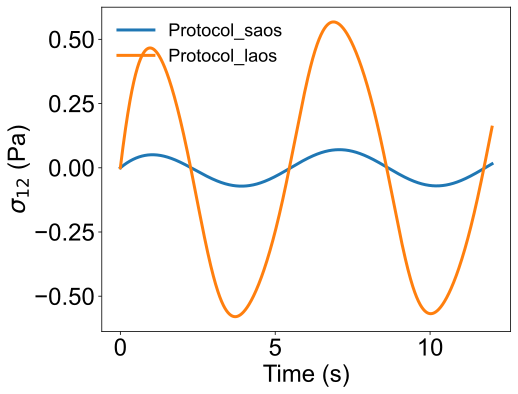

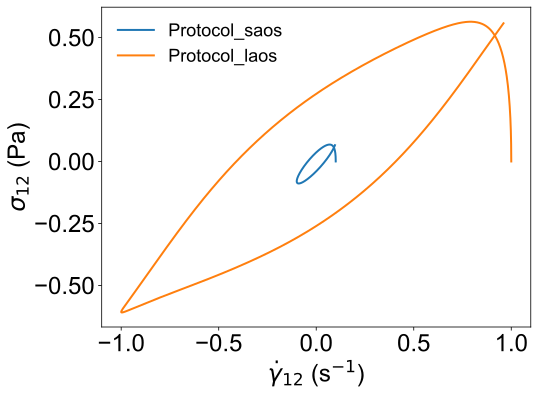

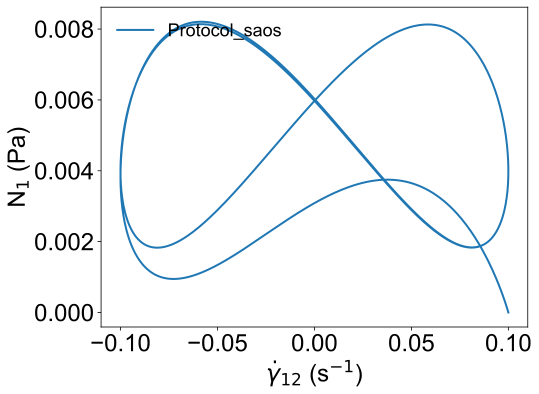

In [20]:
import numpy as np
from scipy.integrate import solve_ivp
import matplotlib.pyplot as plt
import openpyxl
plt.rcParams['font.family'] = 'Arial'  # 设置字体为 Arial
plt.rcParams['font.size'] = 24
%config InlineBackend.figure_format = 'svg'
# 定义吉泽克斯模型微分方程
def dudt_giesekus(t, u, p, gradv):
    # 解构参数
    η0, τ, α = p

    # 应力张量的分量
    σ11, σ22, σ33, σ12, σ13, σ23 = u

    # 速度梯度张量
    v11, v12, v13, v21, v22, v23, v31, v32, v33 = gradv

    # 计算应变率（对称）和涡度（反对称）张量
    γd11 = 2 * v11(t)
    γd22 = 2 * v22(t)
    γd33 = 2 * v33(t)
    γd12 = v12(t) + v21(t)
    γd13 = v13(t) + v31(t)
    γd23 = v23(t) + v32(t)
    ω12 = v12(t) - v21(t)
    ω13 = v13(t) - v31(t)
    ω23 = v23(t) - v32(t)
    # 定义 Giesekus 模型的 F
    F11 = -τ * (σ11 * γd11 + σ12 * γd12 + σ13 * γd13) + (α * τ / η0) * (σ11**2 + σ12**2 + σ13**2)
    F22 = -τ * (σ12 * γd12 + σ22 * γd22 + σ23 * γd23) + (α * τ / η0) * (σ12**2 + σ22**2 + σ23**2)
    F33 = -τ * (σ13 * γd13 + σ23 * γd23 + σ33 * γd33) + (α * τ / η0) * (σ13**2 + σ23**2 + σ33**2)
    F12 = (-τ * (σ11 * γd12 + σ12 * γd22 + σ13 * γd23 + γd11 * σ12 + γd12 * σ22 + γd13 * σ23) / 2
           +
           (α * τ / η0) * (σ11 * σ12 + σ12 * σ22 + σ13 * σ23))
    F13 = (-τ * (σ11 * γd13 + σ12 * γd23 + σ13 * γd33 + γd11 * σ13 + γd12 * σ23 + γd13 * σ33) / 2
           +
           (α * τ / η0) * (σ11 * σ13 + σ12 * σ23 + σ13 * σ33))
    F23 = (-τ * (σ12 * γd13 + σ22 * γd23 + σ23 * γd33 + γd12 * σ13 + γd22 * σ23 + γd23 * σ33) / 2
           +
           (α * τ / η0) * (σ12 * σ13 + σ22 * σ23 + σ23 * σ33))

    # 模型微分方程
    du = np.zeros(6)
    du[0] = η0 * γd11 / τ - σ11 / τ - (ω12 * σ12 + ω13 * σ13) - F11 / τ
    du[1] = η0 * γd22 / τ - σ22 / τ - (ω23 * σ23 - ω12 * σ12) - F22 / τ
    du[2] = η0 * γd33 / τ - σ33 / τ + (ω13 * σ13 + ω23 * σ23) - F33 / τ
    du[3] = η0 * γd12 / τ - σ12 / τ - (ω12 * σ22 + ω13 * σ23 - σ11 * ω12 + σ13 * ω23) / 2 - F12 / τ
    du[4] = η0 * γd13 / τ - σ13 / τ - (ω12 * σ23 + ω13 * σ33 - σ11 * ω13 - σ12 * ω23) / 2 - F13 / τ
    du[5] = η0 * γd23 / τ - σ23 / τ - (ω23 * σ33 - ω12 * σ13 - σ12 * ω13 - σ22 * ω23) / 2 - F23 / τ

    return du

# 计算应变率
def compute_strain_rate(gradv, t):
    v11, v12, v13, v21, v22, v23, v31, v32, v33 = gradv

    # 计算应变率（对称）张量
    γd11 = 2 * v11(t)
    γd22 = 2 * v22(t)
    γd33 = 2 * v33(t)
    γd12 = v12(t) + v21(t)
    γd13 = v13(t) + v31(t)
    γd23 = v23(t) + v32(t)

    return [γd11, γd22, γd33, γd12, γd13, γd23]

# 生成 Giesekus 模型结果
def gen_giesekus_results(protocols, σ0, tspan, p_giesekus, datatype):
    wb = openpyxl.Workbook()

    # 初始化存储数据的列表
    all_time = []
    all_σ12_data = []
    all_γd12_data = []
    all_N1_data = []

    for k, gradv in enumerate(protocols):
        # 求解 Giesekus 模型
        def dudt(t, u):
            return dudt_giesekus(t, u, p_giesekus, gradv)

        sol = solve_ivp(dudt, tspan[:2], σ0, method='RK45', t_eval=np.linspace(tspan[0], tspan[1], tspan[2]))

        # 计算应变率
        strain_rate_data = np.array([compute_strain_rate(gradv, t) for t in sol.t]).T

        # 提取应力数据
        σ11_data = sol.y[0]
        σ22_data = sol.y[1]
        σ33_data = sol.y[2]
        σ12_data = sol.y[3]
        σ13_data = sol.y[4]
        σ23_data = sol.y[5]

        # 提取应变率数据
        γd11_data = strain_rate_data[0]
        γd22_data = strain_rate_data[1]
        γd33_data = strain_rate_data[2]
        γd12_data = strain_rate_data[3]
        γd13_data = strain_rate_data[4]
        γd23_data = strain_rate_data[5]

        # 累积数据
        all_time.append(sol.t)
        all_σ12_data.append(σ12_data)
        all_γd12_data.append(γd12_data)
        all_N1_data.append(σ11_data - σ22_data)

        # 将数据写入 Excel 文件
        sheet = wb.create_sheet(title=f"protocol_{k+1}")
        headers = ["Time", "γd11", "γd22", "γd33", "γd12", "γd13", "γd23", "σ11", "σ22", "σ33", "σ12", "σ13", "σ23"]
        for col_idx, header in enumerate(headers, start=1):
            sheet.cell(row=1, column=col_idx, value=header)

        for row_idx, t in enumerate(sol.t, start=2):
            sheet.cell(row=row_idx, column=1, value=t)
            sheet.cell(row=row_idx, column=2, value=γd11_data[row_idx - 2])
            sheet.cell(row=row_idx, column=3, value=γd22_data[row_idx - 2])
            sheet.cell(row=row_idx, column=4, value=γd33_data[row_idx - 2])
            sheet.cell(row=row_idx, column=5, value=γd12_data[row_idx - 2])
            sheet.cell(row=row_idx, column=6, value=γd13_data[row_idx - 2])
            sheet.cell(row=row_idx, column=7, value=γd23_data[row_idx - 2])
            sheet.cell(row=row_idx, column=8, value=σ11_data[row_idx - 2])
            sheet.cell(row=row_idx, column=9, value=σ22_data[row_idx - 2])
            sheet.cell(row=row_idx, column=10, value=σ33_data[row_idx - 2])
            sheet.cell(row=row_idx, column=11, value=σ12_data[row_idx - 2])
            sheet.cell(row=row_idx, column=12, value=σ13_data[row_idx - 2])
            sheet.cell(row=row_idx, column=13, value=σ23_data[row_idx - 2])

    # 删除默认的 Sheet
    if "Sheet" in wb.sheetnames:
        wb.remove(wb["Sheet"])

    wb.save(f"data/giesekus_model_saos2laos_data.xlsx")

    # 设置默认字体为Arial，字体大小为24
    plt.rcParams['font.family'] = 'Arial'
    plt.rcParams['font.size'] = 24

    # 1. 绘制时间-应力图
    fig1, ax1 = plt.subplots(figsize=(8, 6),dpi=600)
    ax1.plot(all_time[0], all_σ12_data[0], linewidth=3, label=f'Protocol_saos')
    ax1.plot(all_time[8], all_σ12_data[8], linewidth=3, label=f'Protocol_laos')

    ax1.set_xlabel("Time (s)")
    ax1.set_ylabel("$\sigma_{12}$ (Pa)")
    ax1.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
    plt.tight_layout()  # 调整布局
    plt.show()

    # 2. 绘制应变率-应力图
    fig2, ax2 = plt.subplots(figsize=(8, 6),dpi=600)

    ax2.plot(all_γd12_data[2], all_σ12_data[2], linewidth=2, label=f"Protocol_saos")
    ax2.plot(all_γd12_data[9], all_σ12_data[9], linewidth=2, label=f"Protocol_laos")

    ax2.set_xlabel(r"$\dot{\gamma}_{12}$ (s$^{-1}$)")
    ax2.set_ylabel("$\sigma_{12}$ (Pa)")
    ax2.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
    plt.tight_layout()  # 调整布局
    plt.show()

    # 3. 绘制应变率-第一法向应力差图
    fig3, ax3 = plt.subplots(figsize=(8, 6),dpi=600)
 
    ax3.plot(all_γd12_data[0], all_N1_data[0], linewidth=2, label=f"Protocol_saos")
    #ax3.plot(all_γd12_data[8], all_N1_data[8], linewidth=2, label=f"Protocol_laos")

    ax3.set_xlabel(r"$\dot{\gamma}_{12}$ (s$^{-1}$)")
    ax3.set_ylabel("N$_1$ (Pa)")
    ax3.legend(fontsize=18,loc='upper left', frameon=False)  # 添加图例
   # ax3.set_ylim([0, 2.1])
    plt.tight_layout()  # 调整布局
    plt.show()

# 求解 Giesekus 模型的参数
η0 = 1
τ = 1
α = 0.8
p_giesekus = [η0, τ, α]

# 生成训练集
# 定义简单剪切变形协议
def v11(t): return 0
def v12(t): return 0
def v13(t): return 0
def v22(t): return 0
def v23(t): return 0
def v31(t): return 0
def v32(t): return 0
def v33(t): return 0

# 初始条件和时间范围
tspan = (0.0, 12.0,1000) # 起始时间、终末时间、时间点数量
σ0 = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]

# 构建不同实验的协议
ω = 1.0
saos_gamma0=0.1
laos_gamma0=0.5
def v21_1(t): return saos_gamma0 * np.cos(ω * t)
def v21_2(t): return 2*saos_gamma0 * np.cos(ω * t)
def v21_3(t): return saos_gamma0 * np.cos(ω * t / 2)
def v21_4(t): return 2 *saos_gamma0* np.cos(ω * t / 2)
def v21_5(t): return saos_gamma0 * np.cos(2 * ω * t)
def v21_6(t): return 2*saos_gamma0 * np.cos(2 * ω * t)
def v21_7(t): return saos_gamma0 * np.cos(ω * t / 3)
def v21_8(t): return 2*saos_gamma0 * np.cos(ω * t / 3)
def v21_9(t): return 2*laos_gamma0 * np.cos(ω * t )
def v21_10(t): return 2*laos_gamma0 * np.cos(ω * t / 2)
def v21_11(t): return 2*laos_gamma0 * np.cos(ω * t / 3)

gradv_1 = [v11, v12, v13, v21_1, v22, v23, v31, v32, v33]
gradv_2 = [v11, v12, v13, v21_2, v22, v23, v31, v32, v33]
gradv_3 = [v11, v12, v13, v21_3, v22, v23, v31, v32, v33]
gradv_4 = [v11, v12, v13, v21_4, v22, v23, v31, v32, v33]
gradv_5 = [v11, v12, v13, v21_5, v22, v23, v31, v32, v33]
gradv_6 = [v11, v12, v13, v21_6, v22, v23, v31, v32, v33]
gradv_7 = [v11, v12, v13, v21_7, v22, v23, v31, v32, v33]
gradv_8 = [v11, v12, v13, v21_8, v22, v23, v31, v32, v33]
gradv_9 = [v11, v12, v13, v21_9, v22, v23, v31, v32, v33]
gradv_10 = [v11, v12, v13, v21_10, v22, v23, v31, v32, v33]
gradv_11 = [v11, v12, v13, v21_11, v22, v23, v31, v32, v33]

protocols = [gradv_1, gradv_2, gradv_3, gradv_4, gradv_5, gradv_6, gradv_7, gradv_8,gradv_9,gradv_10,gradv_11]

gen_giesekus_results(protocols, σ0, tspan, p_giesekus, "train")